# XAI605 Midterm – MDN Training & Evaluation (Annotated)

## 1) Load & Inspect Noisy Training Data

In [1]:
# SECTION 1 — Load noisy training data from data2/noisy_data.npz and print the available keys and shapes.
# No logic changes: this only documents data inspection.

import numpy as np
import matplotlib.pyplot as plt
from jit_wrap import save_jit_model
from local_mdn import get_argmax_mu
import os

data_train = np.load('data2/noisy_data.npz')

print("Keys in file:", data_train.files)
for key in data_train.files:
    print(f"{key}: shape = {data_train[key].shape}")

Keys in file: ['x', 'y']
x: shape = (800, 1)
y: shape = (800, 1)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2) Visualize Noisy Training Data

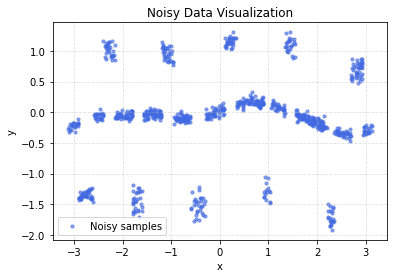

In [2]:
# SECTION 2 — Scatter-plot the noisy (x, y) samples for a quick visual check.
# Axes labels, title, legend, and grid are purely for readability.

x_train_in = data_train["x"]
y_train_in = data_train["y"]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x_train_in, y_train_in, s=10, alpha=0.6, color="royalblue", label="Noisy samples")
plt.title("Noisy Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

Keys in file: ['x', 'y']
x: shape = (800, 1)
y: shape = (800, 1)


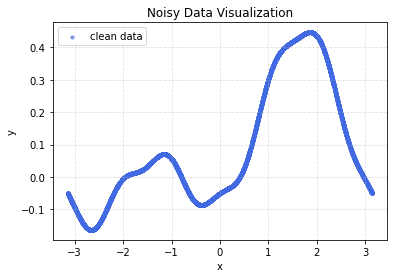

In [3]:
data_test = np.load('data1/clean_data.npz')

print("Keys in file:", data_train.files)
for key in data_train.files:
    print(f"{key}: shape = {data_train[key].shape}")

x_test = data_test["x"]
y_test = data_test["y"]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x_test, y_test, s=10, alpha=0.6, color="royalblue", label="clean data")
plt.title("Noisy Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

## 3) Import Utilities & MDN Components

In [4]:
# SECTION 3 — Import Torch & supporting utilities (e.g., MixtureDensityNetwork, gmm_forward, eval_mdn_1d).
# Also prints torch version info (including CUDA compiled into the wheel).

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)
print("cuda in wheel:", torch.version.cuda)
from util import (
    get_torch_size_string,
    print_model_parameters,
    th2np,
)
from local_mdn import (
    MixtureDensityNetwork,
    gmm_forward,
    eval_mdn_1d,
)

2.8.0+cu128
cuda in wheel: 12.8


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.version.cuda

'12.8'

## 4) Build MDN Model + Optimizer/Scheduler

In [6]:
# SECTION 4 — Instantiate the Mixture Density Network (MDN) with K Gaussians and a small MLP backbone.
# Initialize parameters, configure Adam optimizer and an exponential LR scheduler.

# when you build the model (keep k=5 if you like)
mdn = MixtureDensityNetwork(
    name='mdn',
    x_dim=1, y_dim=1, k=5,
    h_dim_list=[64,64],
    actv=nn.SiLU(),
    sig_max=10.0,  # <= tighten
    mu_min=-0.02,      # <= widen (in normalized units)
    mu_max=+0.02,
    p_drop=0.0, use_bn=False,
).to(device)
mdn.init_param()
optm = torch.optim.Adam(mdn.parameters(), lr=3.2e-5, eps=1e-4, weight_decay=1e-4)
schd = torch.optim.lr_scheduler.ExponentialLR(optm, gamma=0.9999)

## 5) Prepare Training Tensors & Limits

In [7]:
# SECTION 5 — Move training arrays to tensors on the chosen device; set training size (n_train).

n_train = 800
x_train = torch.from_numpy(x_train_in).to(device)
y_train = torch.from_numpy(y_train_in).to(device)

## 6) Training Hyperparameters

In [8]:
# SECTION 6 — Define total iterations, batch size, logging cadence (print_every) and plotting cadence (plot_every).

max_iter,batch_size,print_every,plot_every = 2e4,64,1000,5000
print ("max_iter:[%d] batch_size:[%d] print_every:[%d] plot_every:[%d]"%
      (max_iter,batch_size,print_every,plot_every))

max_iter:[20000] batch_size:[64] print_every:[1000] plot_every:[5000]


## 7) Initialize Training Session

## 8) Training Loop (MDN forward + NLL + step + schedule + logging/plotting)

Start training
[   0/20000] loss:[6.993]


/tmp/ipykernel_4035/3712690271.py:30: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print ("[%4d/%d] loss:[%.3f]"%(it,max_iter,loss))


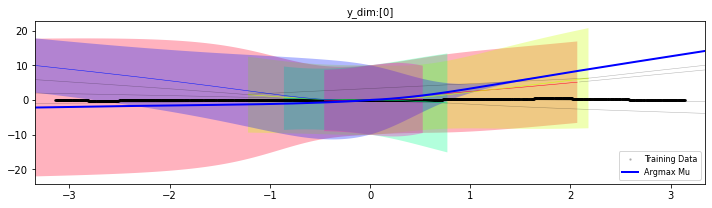

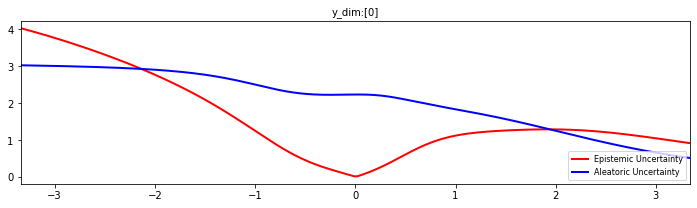

[1000/20000] loss:[1.246]
[2000/20000] loss:[1.281]
[3000/20000] loss:[1.312]
[4000/20000] loss:[1.235]
[5000/20000] loss:[1.274]


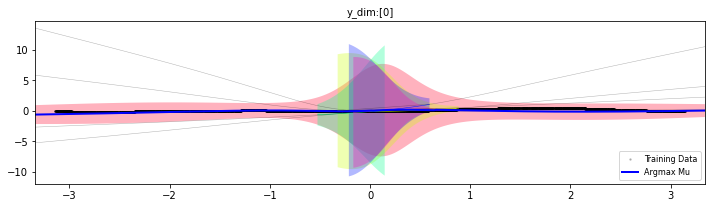

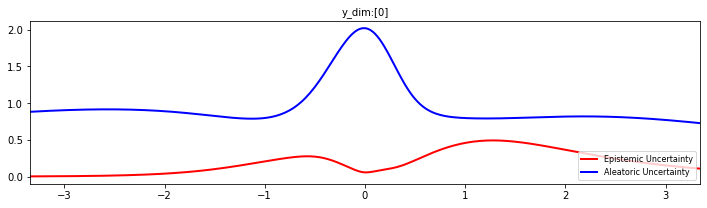

[6000/20000] loss:[1.201]
[7000/20000] loss:[1.194]
[8000/20000] loss:[1.104]
[9000/20000] loss:[0.993]
[10000/20000] loss:[0.932]


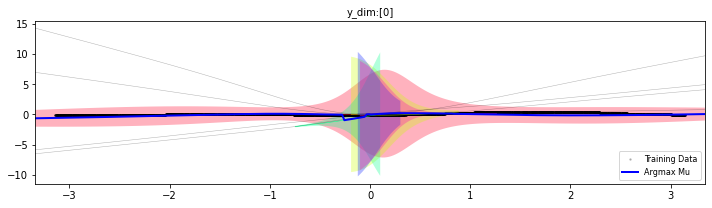

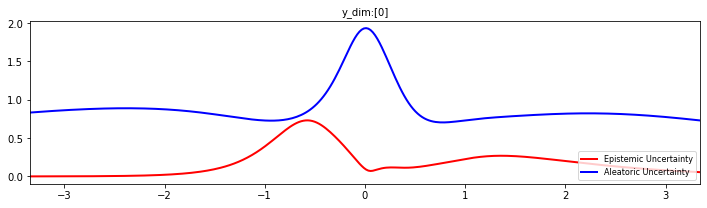

[11000/20000] loss:[1.041]
[12000/20000] loss:[1.203]
[13000/20000] loss:[1.003]
[14000/20000] loss:[0.968]
[15000/20000] loss:[1.121]


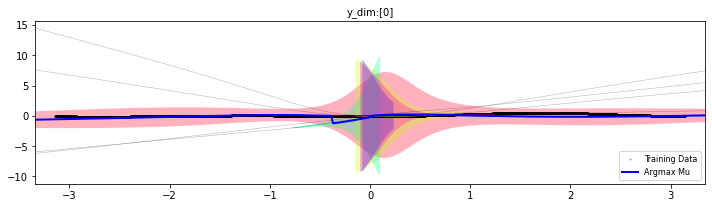

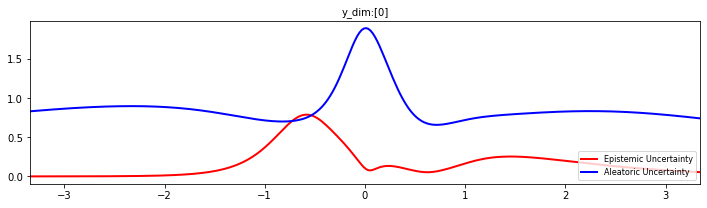

[16000/20000] loss:[0.989]
[17000/20000] loss:[0.834]
[18000/20000] loss:[1.082]
[19000/20000] loss:[1.082]
[19999/20000] loss:[1.097]


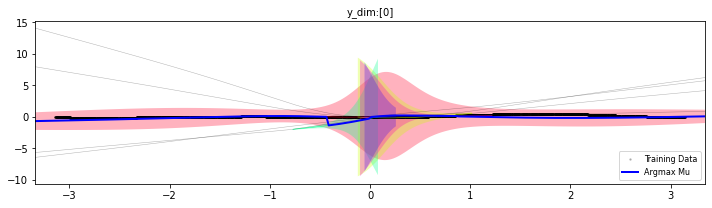

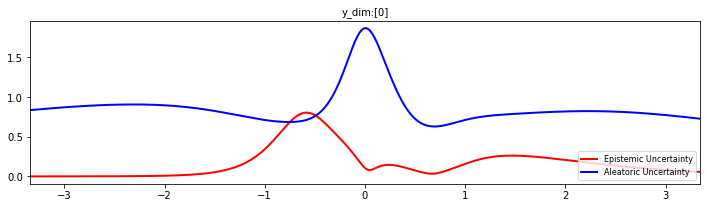

Done.


In [9]:
# SECTION 8 — Core training loop:
#  • sample mini-batches; forward pass → (π, μ, σ); compute GMM negative log-likelihood against targets;
#  • backward(); optimizer step; LR scheduler step;
#  • periodic logging and plotting via eval_mdn_1d.
# No functional changes: comments only.

print ("Start training")
np.random.seed(seed=0)
torch.manual_seed(seed=0)
mdn.init_param()
mdn.train()
x_train = torch.Tensor(x_train_in).to(device)
y_train = torch.Tensor(y_train_in).to(device)

for it in range(int(max_iter)):
    batch_idx = np.random.permutation(n_train)[:batch_size]
    x_batch,y_batch = x_train[batch_idx],y_train[batch_idx]

    # Update
    mdn.zero_grad()
    pi_batch,mu_batch,sigma_batch = mdn.forward(x_batch)
    gmm_out = gmm_forward(pi_batch,mu_batch,sigma_batch,y_batch)
    loss = torch.mean(gmm_out['nlls']) + 0.1*F.mse_loss(y_batch,gmm_out['argmax_mu'])
    loss.backward()
    optm.step()
    schd.step()
    
    # Print
    if ((it%print_every)==0) or (it==(max_iter-1)):
        print ("[%4d/%d] loss:[%.3f]"%(it,max_iter,loss))

    # Plot
    if ((it%plot_every)==0) or (it==(max_iter-1)):
        eval_mdn_1d(mdn,x_test,y_test,figsize=(12,3),device=device)
print("Done.")
    



## 9) Validation / Argmax-μ Prediction & Visualization

Loading validation data 'validation_data.npz'...
Validation data loaded successfully.


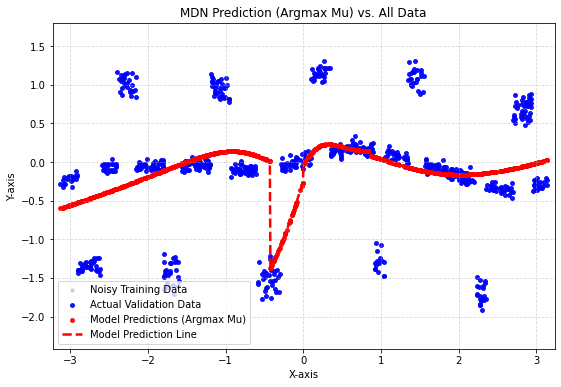

In [10]:
# SECTION 9 — Load a validation split, run MDN forward pass, and derive predictions via argmax over mixture weights.
# Plot predicted curve against validation & training points for a qualitative check.

print("Loading validation data 'validation_data.npz'...")
val_data = np.load('./data2/noisy_data.npz')
x_val = val_data['x']
y_val = val_data['y']
print("Validation data loaded successfully.")
    
# Prepare validation data (reshape and convert to tensor)
# ...existing code...
# Prepare validation data (reshape and convert to tensor)
if x_val.ndim == 1: x_val = x_val.reshape(-1, 1)
if y_val.ndim == 1: y_val = y_val.reshape(-1, 1)

# send validation inputs to the same device as the model
x_val_tensor = torch.tensor(x_val).float().to(device)

# Set model to evaluation mode
mdn.eval()

# Get model predictions for the validation set
with torch.no_grad():
    pi_val, mu_val, sigma_val = mdn(x_val_tensor)
    y_val_pred_tensor = get_argmax_mu(pi_val, mu_val)

# Convert tensors to NumPy (ensure CPU)
y_val_pred_np = th2np(y_val_pred_tensor)
x_val_np = th2np(x_val_tensor)
# if x_train/y_train are torch tensors, convert them for plotting:
x_train_np = th2np(x_train) if isinstance(x_train, torch.Tensor) else x_train
y_train_np = th2np(y_train) if isinstance(y_train, torch.Tensor) else y_train
y_val_np = y_val  # already numpy

# plotting ...
plt.figure(figsize=(9, 6))
plt.scatter(x_train_np, y_train_np, color='green', label='Noisy Training Data', s=10, alpha=0.2)
plt.scatter(x_val_np, y_val_np, color='blue', label='Actual Validation Data', s=15, alpha=0.9)
plt.scatter(x_val_np, y_val_pred_np, color='red', label='Model Predictions (Argmax Mu)', s=15, alpha=0.9)
sort_indices = np.argsort(x_val_np.squeeze())
plt.plot(x_val_np[sort_indices], y_val_pred_np[sort_indices], color='red', linestyle='--', linewidth=2.5, label='Model Prediction Line')
plt.title('MDN Prediction (Argmax Mu) vs. All Data')
plt.xlabel('X-axis'); plt.ylabel('Y-axis')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(y_train_np.min() - 0.5, y_train_np.max() + 0.5)
plt.xlim(x_train_np.min() - 0.1, x_train_np.max() + 0.1)
plt.show()

## 10) Save TorchScript (JIT) Model

In [11]:
# SECTION 10 — Switch model to eval mode on CPU and export a TorchScript (.pth) using save_jit_model().

# exit()

print("\n--- Saving JIT Model ---")
# Ensure the 'model/' directory exists (relative to notebook)
os.makedirs('model', exist_ok=True)

# Set model to evaluation mode and move to CPU before saving
mdn.eval()
mdn.cpu()

JIT_MODEL_PATH = "model/2025021848.pth"
save_jit_model(mdn, JIT_MODEL_PATH)


--- Saving JIT Model ---
Wrapping model for JIT tracing...
JIT-traced model saved successfully to model/2025021848.pth


## 11) Evaluate Saved Model with eval.py on Clean Data

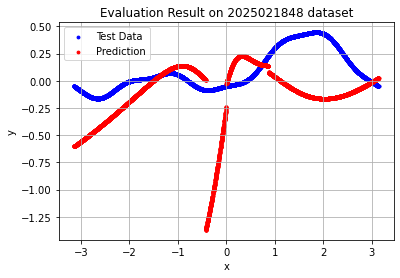

{'name': '2025021848', 'Error': 0.13790955924987794}


In [12]:
# SECTION 11 — Load the saved TorchScript model and call evaluate_model(...) on the clean practice set (data1).
# This mirrors the grading pathway and verifies the artifact loads & runs correctly.

from eval import evaluate_model
# load each train dataset, val dataset, test dataset
data_test = np.load(f"data1/clean_data.npz")
xt, yt = data_test["x"], data_test["y"]

mdn = torch.jit.load(f"model/2025021848.pth", map_location="cpu")
res = evaluate_model("2025021848", xt, yt, mdn, PLOT=True)
print(res)